<a href="https://colab.research.google.com/github/d-yacenko/article_text_processing/blob/main/network2_vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gensim.downloader as api

In [2]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [3]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!
#pretrained = api.load('glove-twitter-25') # 100 Mb
VEC_SIZE = 300

In [4]:
import warnings
warnings.filterwarnings('ignore')
import sys

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import random 
RND=0

random.seed(RND)
np.random.seed(RND)
torch.manual_seed(RND)
torch.cuda.manual_seed(RND)
torch.backends.cudnn.deterministic = True


In [5]:
# pretrained['listeners'].shape

In [6]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [7]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq



In [8]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(train_tokenized[0])

['from', 'lerxst', 'where', 'thing', 'subject', 'what', 'this', 'nntp', 'posting', 'host', 'rac3', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'there', 'could', 'enlighten', 'this', 'other', 'door', 'sports', 'looked', 'from', 'late', 'early', 'called', 'bricklin', 'doors', 'were', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'from', 'rest', 'body', 'this', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'where', 'this', 'made', 'history', 'whatever', 'info', 'have', 'this', 'funky', 'looking', 'please', 'mail', 'thanks', 'brought', 'your', 'neighborhood', 'lerxst']


In [9]:
print(len(train_source['data']))

11314


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

MAX_TEXT_LEN=280
TRAIN='train'
TEST='test'
# Create dataset here
class TextDataset(Dataset):
    """Chars dataset."""

    def __init__(self, SRC):
        """   """
        if SRC==TRAIN:
            self.DATA = train_source
            self.TOKENIZED = train_tokenized
        else:
            self.DATA = test_source
            self.TOKENIZED = test_tokenized
        self.size=len(self.DATA['data'])

    def __len__(self):
        return len(self.DATA['data'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        result=self.DATA['target'][idx]
        data_item=[]
        i=0
        for word in self.TOKENIZED[idx]:
            if i==MAX_TEXT_LEN: break
            if word in pretrained.key_to_index:
                i+=1
                vec_of_word=pretrained.get_vector(word)
                data_item.append(vec_of_word)
        data_item=torch.FloatTensor(data_item)
        if i<MAX_TEXT_LEN:
            # здесь VEC_SIZE длинна вектора. нужно наверное программно извлекать из w2vec
            data_item=torch.cat((data_item,torch.zeros(MAX_TEXT_LEN-i, VEC_SIZE, dtype=torch.float)))
        return data_item,result

text_datasets = {x: TextDataset(x)
                  for x in [TRAIN, TEST]}
dataloaders = {x: torch.utils.data.DataLoader(text_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=4)
              for x in [TRAIN, TEST]}
dataset_sizes = {x: len(text_datasets[x]) for x in [TRAIN, TEST]}


In [11]:
print(len(text_datasets))
data_item,result=text_datasets[TRAIN][0]
data_item,result=text_datasets[TEST][0]
print(len(text_datasets[TRAIN]))
print(len(text_datasets[TEST]))
print(result)
print(data_item.shape)
print(data_item[:100])

2
11314
7532
7
torch.Size([280, 300])
tensor([[ 5.8105e-02, -1.7452e-04,  7.6172e-02,  ...,  1.0132e-02,
          6.4453e-02, -2.9663e-02],
        [-3.7598e-02,  1.1523e-01, -9.4238e-02,  ..., -4.1748e-02,
          1.8433e-02, -1.0107e-01],
        [-1.1572e-01,  1.6406e-01,  9.1309e-02,  ..., -2.6367e-01,
         -2.1362e-02, -5.4443e-02],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [12]:
data_item,result=text_datasets[TRAIN][0]

In [13]:
m = nn.AdaptiveMaxPool1d(2)
input = torch.randn(1, 5, 8)
output = m(input)
print(input.shape)
print(output.shape)
print(input)
print(output)

torch.Size([1, 5, 8])
torch.Size([1, 5, 2])
tensor([[[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160,
          -2.1152],
         [ 0.3223, -1.2633,  0.3500,  0.3081,  0.1198,  1.2377,  1.1168,
          -0.2473],
         [-1.3527, -1.6959,  0.5667,  0.7935,  0.5988, -1.5551, -0.3414,
           1.8530],
         [-0.2159, -0.7425,  0.5627,  0.2596, -0.1740, -0.6787,  0.9383,
           0.4889],
         [ 1.2032,  0.0845, -1.2001, -0.0048, -0.5181, -0.3067, -1.5810,
           1.7066]]])
tensor([[[-0.2506,  0.8487],
         [ 0.3500,  1.2377],
         [ 0.7935,  1.8530],
         [ 0.5627,  0.9383],
         [ 1.2032,  1.7066]]])


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


class DCCNet(torch.nn.Module):
    def __init__(self,channel,num_out):
        super(DCCNet, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  # https://stackoverflow.com/questions/61370554/using-moduledict-i-have-input-type-torch-cuda-floattensor-and-weight-type-t
        
        l=torch.nn.ModuleList()
        self.layers.append(l)
        # https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29
        # https://medium.com/@sumanshusamarora/understanding-pytorch-conv1d-shapes-for-text-classification-c1e1857f8533
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        # l.append(torch.nn.BatchNorm1d(num_features=channel))
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.Dropout(0.05))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        # l.append(torch.nn.BatchNorm1d(num_features=channel))
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.Dropout(0.05))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.BatchNorm1d(num_features=channel))
        l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        l.append(torch.nn.RReLU())
        l.append(torch.nn.Dropout(0.05))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        # l=torch.nn.ModuleList()
        # self.layers.append(l)
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        # l=torch.nn.ModuleList()
        # self.layers.append(l)
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.BatchNorm1d(num_features=channel))
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.Dropout(0.05))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        # l=torch.nn.ModuleList()
        # self.layers.append(l)
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        # l=torch.nn.ModuleList()
        # self.layers.append(l)
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.BatchNorm1d(num_features=channel))
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.Dropout(0.05))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))

        # l=torch.nn.ModuleList()
        # self.layers.append(l)
        # l.append(torch.nn.Conv1d(channel,channel,3,padding=1))
        # l.append(torch.nn.ReLU())
        # l.append(torch.nn.MaxPool1d(2,2))
        # l.append(torch.nn.BatchNorm1d(num_features=channel))


        self.ga = torch.nn.AdaptiveMaxPool1d(1)
        self.flat = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(1*VEC_SIZE,num_out)
        # self.cactiv4 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(1024,num_out)
        #self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        # x = self.cactiv4(x)
        # x = self.fc2(x)
        return x

    def _forward(self, x):
        n=1 
        x=x.permute(0,2,1)
        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))
          if n%2 != 0:
            x_=x
          else:
            x=x+x_    
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        x = self.ga(x)
        x=x.permute(0,2,1)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        #x = self.sm(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        #x = self.sm(x)
        return x

In [15]:
input = torch.randn(7, 16, 5)
print(input.shape)
m = nn.Conv1d(16, 1, 3)
output = m(input)
#print(input)
#print(output)

torch.Size([7, 16, 5])


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
import time
import copy
EPOCHS=100
hist_train_loss=[]
hist_train_acc=[]
hist_test_loss=[]
hist_test_acc=[]
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = sys.maxsize
    best_acc = -sys.maxsize - 1 
    early_stopping=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [TRAIN, TEST]:
            if phase == TEST:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model.forward(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == TRAIN:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == TEST: 
                hist_test_loss.append(epoch_loss)
                hist_test_acc.append(epoch_acc)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping = early_stopping+1 if early_stopping<0 else 0
                else:
                    early_stopping -=1
            else:
                hist_train_loss.append(epoch_loss)
                hist_train_acc.append(epoch_acc)

        print()
        if early_stopping<-15: 
            print("finest loss reached")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    str_res='Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)+'Best val Acc: {:4f}'.format(best_acc)

    # ,padding=1load best model weights
    model.load_state_dict(best_model_wts)
    return model,str_res

In [18]:
model_ft = DCCNet(VEC_SIZE,20)
#model_ft = models.alexnet()
num_ftrs = model_ft.parameters()
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft,str_res = train_model(model_ft,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=EPOCHS)

Epoch 0/99
----------
--->   torch.Size([100, 300, 280])
--->   torch.Size([100, 300, 280])
--->   torch.Size([100, 300, 140])
====
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 140])
====
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 140])
--->   torch.Size([100, 300, 70])
====
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 70])
====
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 70])
--->   torch.Size([100, 300, 35])
====
--->   torch.Size([100, 300, 35])
--->   torch.Size([100, 300, 35])
--->   torch.Size([100, 300, 35])
--->   torch.Size([100, 300, 35])
--->   torch.Size([100, 300, 35])
--->   torch.Size([100, 300, 35])
====
train Loss: 2.0902 Acc: 0.2766
test Loss: 2.0320 Acc: 0.4023

Epoch 1/99
----------
trai

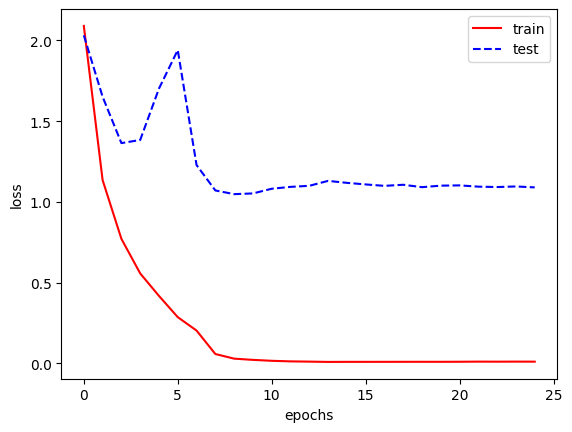

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0,len(hist_train_loss)),hist_train_loss,c='r',label="train")
plt.plot(np.arange(0,len(hist_test_loss)),hist_test_loss,c='b',linestyle='dashed',label="test")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("fig8.png")

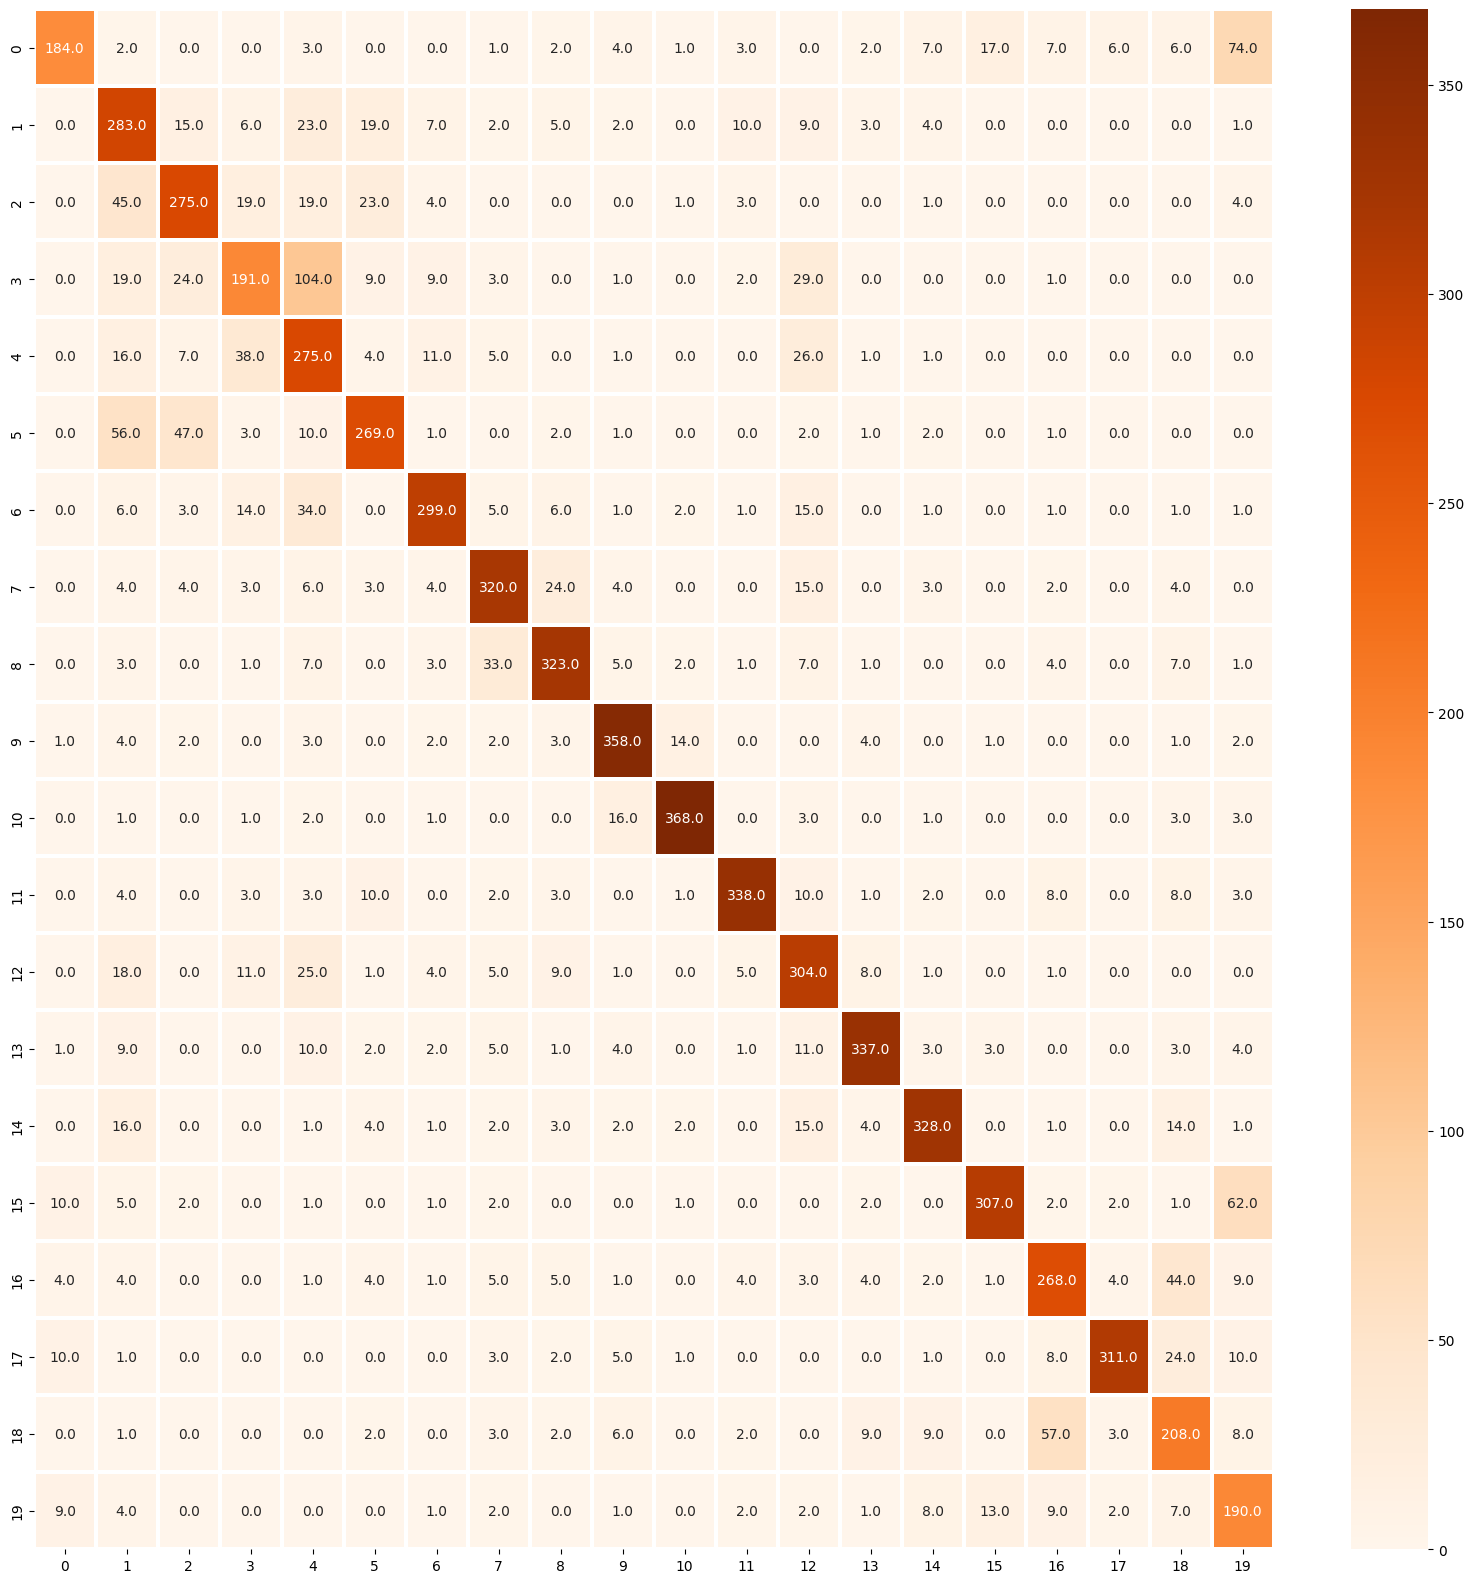

In [25]:
from sklearn import metrics
class_names =  train_source.target_names
true_labels=[]
pred_labels=[]
model_ft.eval()
for inputs,labels in dataloaders[TEST]:
    pred = model_ft.forward(inputs.to(device))
    _, pred = torch.max(pred, 1)
    labels.to(torch.device("cpu"))
    pred.to(torch.device("cpu"))
    true_labels.extend(labels.tolist());
    pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
# print(cm)
from pandas import DataFrame
import seaborn as sn

df_cm = DataFrame(cm, index=np.arange(0,len(class_names)), columns=np.arange(0,len(class_names)))
plt.subplots(figsize=(20,20))
ax = sn.heatmap(df_cm,fmt=".1f",linewidths=1.5,cmap='Oranges', annot=True)
plt.savefig("fig9.png")